# Εργασία 1

## Α. Αναγνώριση μονών και ζυγών αριθμών στα δεκαδικά ψηφία της MNIST

### 1. Προετοιμασία των δεδομένων

Σκοπός της εργασίας είναι η αξιολόγηση μοντέλων τα οποία κατηγοριοποιούν εικόνες από χειρόγραφα ψηφία σε μονούς και ζυγούς αριθμούς.

Παρακάτω βλέπουμε τις εκδόσεις της python και των βιβλιοθηκών που χρησιμοποιήθηκαν στην εργασία.

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import sklearn
import cvxopt
import sys

print('Python version:', sys.version)
print('scikit-learn version:', sklearn.__version__)
print('numpy version:', np.__version__)
print('matplotlib version:', matplotlib.__version__)
print('pandas version', pd.__version__)
print('cvxopt version', cvxopt.__version__)

Python version: 3.7.9 (default, Aug 31 2020, 17:10:11) [MSC v.1916 64 bit (AMD64)]
scikit-learn version: 0.23.2
numpy version: 1.19.2
matplotlib version: 3.3.2
pandas version 1.1.3
cvxopt version 1.2.0


Τα δεδομένα περιέχονται στο αρχείο mnist_all.mat. Το διάβασμα του αρχείου γίνεται με την συνάρτηση scipy.io.loadmat η οποία επιστρέφει ένα dictionary το οποίο έχει κλειδια τα 'train0', 'train1', 'train2',... και 'test0', 'test1', 'test2',... και data τις εικόνες των αντίστοιχων ψηφίων.

In [2]:
import scipy.io
import urllib.request
import os

np.random.seed(0)

url = 'https://cs.nyu.edu/~roweis/data/mnist_all.mat'
filename = 'mnist_all.mat'

if not os.path.exists(filename):
    print('Downloading file...')
    urllib.request.urlretrieve(url, filename)
    print('Done.')

mat = scipy.io.loadmat(filename)
mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'train0', 'test0', 'train1', 'test1', 'train2', 'test2', 'train3', 'test3', 'train4', 'test4', 'train5', 'test5', 'train6', 'test6', 'train7', 'test7', 'train8', 'test8', 'train9', 'test9'])

Οι εικόνες των ψηφίων έχουν μέγεθος 784 = 28x28.

In [3]:
digit = mat['train2'][0]
digit.shape

(784,)

Παρακάτω φαίνονται οι εικόνες πέντε ψηφίων.

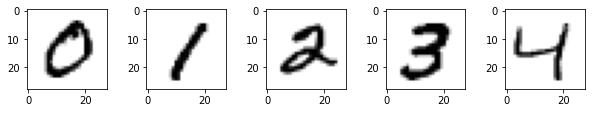

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

n = 5
fig, axs = plt.subplots(1, n, figsize=(10, 10))
plt.subplots_adjust(wspace=0.5)
for i in range(n):
    digit = mat['train' + str(i)][0]
    digit = digit.reshape((28, 28))
    axs[i].imshow(digit, cmap=plt.cm.binary)
plt.show()

Οι είκονες και οι ετικέτες φορτώνονται σε numpy arrays. Το μέγεθος του training set είναι 60000 και του test set 10000. Η κανονικοποίηση στο διάστημα [0, 1] γίνεται με διαίρεση με το 255 το οποίο είναι η μέγιστη τιμή της φωτεινότητας ενός pixel.

In [5]:
x_train, y_train, x_test, y_test = [], [], [], []

for key, data in mat.items():
    if 'train' in key:
        for x in data:
            x_train.append(x)
            num = int(key[-1])
            y_train.append(num)
    if 'test' in key:
        for x in data:
            x_test.append(x)
            num = int(key[-1])
            y_test.append(num)

x_train = np.array(x_train, dtype=np.double)
y_train = np.array(y_train, dtype=np.double)
x_test = np.array(x_test, dtype=np.double)
y_test = np.array(y_test, dtype=np.double)
x_test_original = x_test

print('x_train.shape =', x_train.shape)
print('y_train.shape =', y_train.shape)
print('x_test.shape =', x_test.shape)
print('y_test.shape =', y_test.shape)

x_train.shape = (60000, 784)
y_train.shape = (60000,)
x_test.shape = (10000, 784)
y_test.shape = (10000,)


In [6]:
x_train /= 255.
x_test /= 255.

print()
print('x_train is in [{}, {}]'.format(np.min(x_train), np.max(x_train)))
print('x_test is in [{}, {}]'.format(np.min(x_test), np.max(x_test)))


x_train is in [0.0, 1.0]
x_test is in [0.0, 1.0]


Το παρακάτω ιστόγραμμα μας δείχνει ότι οι κλάσεις των ψηφίων είναι ζυγισμένες. 

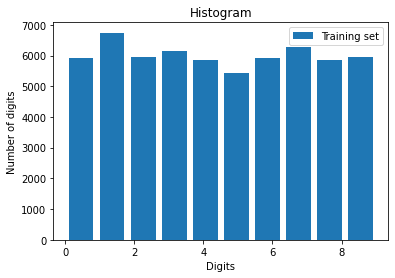

In [7]:
plt.hist(y_train, label='Training set', rwidth=0.8)
plt.title('Histogram')
plt.ylabel('Number of digits')
plt.xlabel('Digits')
plt.legend()
plt.show()

Λόγω του μεγάλου μεγέθους των δεδομένων, ως μέθοδος αξιολόγησης των μοντέλων, για την επιλογή των παραμέτρων τους, επιλέγεται η διαστρωματωμένη παρακράτηση (stratified holdout). Χρησιμοποιώντας αυτή τη μέθοδο χωρίζεται το training set ξανά σε training set και validation set διασφαλίζοντας ότι η κατανομή των κλάσεων παραμένει η ίδια και στα δύο set. Έτσι όλα τα ψηφία αντιπροσωπεύονται ισάξια.

In [8]:
from sklearn import model_selection

x_train_all = x_train
y_train_all = y_train

split = model_selection.StratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=0)

for train_index, val_index in split.split(x_train_all, y_train_all):
    x_train, y_train = x_train_all[train_index], y_train_all[train_index]
    x_val, y_val = x_train_all[val_index], y_train_all[val_index]  

print('x_train_all.shape =', x_train_all.shape)
print('y_train_all.shape =', y_train_all.shape)
print('x_train.shape =', x_train.shape)
print('y_train.shape =', y_train.shape)
print('x_val.shape =', x_val.shape)
print('y_val.shape =', y_val.shape)

x_train_all.shape = (60000, 784)
y_train_all.shape = (60000,)
x_train.shape = (36000, 784)
y_train.shape = (36000,)
x_val.shape = (24000, 784)
y_val.shape = (24000,)


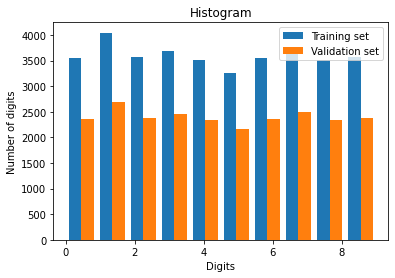

In [9]:
plt.hist((y_train, y_val), label=('Training set', 'Validation set'), rwidth=0.8)
plt.title('Histogram')
plt.ylabel('Number of digits')
plt.xlabel('Digits')
plt.legend()
plt.show()

Αλλάζουμε τις ετικέτες σε -1 και 1 έτσι ώστε να αντιπροσωπεύουν τους ζυγούς και τους μονούς αριθμούς αντίστοιχα.

In [10]:
y_train_all = y_train_all % 2
y_train = y_train % 2
y_val = y_val % 2
y_test = y_test % 2

y_train_all[y_train_all == 0] = -1.0
y_train[y_train == 0] = -1.0
y_val[y_val == 0] = -1.0
y_test[y_test == 0] = -1.0

Ο MySVM classifier χρησιμοποιεί πίνακες που απαιτούν πολλή μνήμη. Για αυτό το λόγο δημιουργείται ένα μικρό training set για την εκπαίδευση, στο οποίο εκπαιδεύονται και classifiers του sklearn για σύγκριση.

In [11]:
x_train_small = x_train[:6000]
y_train_small = y_train[:6000]
x_val_small = x_val[:4000]
y_val_small = y_val[:4000]
x_train_all_small = np.concatenate((x_train_small, x_val_small))
y_train_all_small = np.concatenate((y_train_small, y_val_small))

Το παρακάτω κελί χρησιμοποιείται μόνο για σκοπούς debugging.

In [12]:
# FIXME The following should be in comments
#x_train = x_train[:6000]
#y_train = y_train[:6000]
#x_val = x_val[:4000]
#y_val = y_val[:4000]
#x_train_all = np.concatenate((x_train, x_val))
#y_train_all = np.concatenate((y_train, y_val))
#x_train_small = x_train[:600]
#y_train_small = y_train[:600]
#x_val_small = x_val[:400]
#y_val_small = y_val[:400]
#x_train_all_small = np.concatenate((x_train_small, x_val_small))
#y_train_all_small = np.concatenate((y_train_small, y_val_small))

### 2. Μείωση διαστάσεων

Γίνεται μείωση των διαστάσεων με την τεχνική PCA διατηρώντας το 90% της διασποράς. Η διάσταση των δεδομένων μειώνεται από 784 σε 87.

In [13]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.9, svd_solver='full')
x_train_pca = pca.fit_transform(x_train)
print('Dimension was reduced from {} to {}.'.format(x_train.shape[1], x_train_pca.shape[1]))

Dimension was reduced from 784 to 87.


Οι κλάσεις δεν φαίνονται διαχωρίσιμες στο επίπεδο των δυο πρώτων ιδιοδιανυσμάτων.

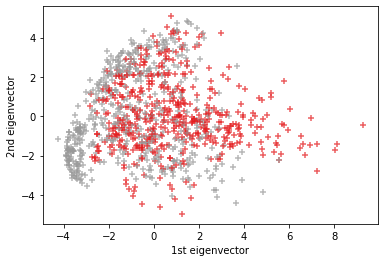

In [14]:
plt.scatter(x_train_pca[:1000, 0], x_train_pca[:1000, 1], c=y_train[:1000], cmap='Set1', marker='+', alpha=0.7)
plt.xlabel('1st eigenvector')
plt.ylabel('2nd eigenvector')
plt.show()

### 3. Υλοποίηση αλγορίθμων

Υλοποιήθηκαν αλγόριθμοι SVM, kPCA και LDA οι οποίοι συγκρίνονται με τους αντίστοιχους της sklearn.

#### 3.1 My SVM

Ακολουθεί υλοποίηση ενός SVM classifier με linear, polynomial και rbf kernel. Ο Quadratic Programming solver της βιβλιοθήκης CVXOPT υπολογίζει τους πολλαπλασιαστές Lagrange του δυϊκού προβλήματος του SVM.

In [15]:
from cvxopt import matrix, solvers

class MySVM(object):
    def __init__(self, C=1.0, kernel='linear', degree=3, gamma='scale', coef0=0.0):
        self.C = C
        self.kernel = kernel
        self.degree = degree
        self.gamma = gamma
        self.coef0 = coef0
        self.sv_x = None
        self.sv_y = None
        self.alphas = None
        self.b = 0
    
    def set_params(self, **params):
        if not params:
            return self
        self.C = params.get('C', self.C)
        self.kernel = params.get('kernel', self.kernel)
        self.degree = params.get('degree', self.degree)
        self.gamma = params.get('gamma', self.gamma)
        self.coef0 = params.get('coef0', self.coef0)
        return self
    
    def _linear_kernel(self, X, Z):
        return np.matmul(X, Z.T)
    
    def _poly_kernel(self, X, Z):
        return np.power(self.gamma*np.matmul(X, Z.T) + self.coef0, self.degree)

    def _rbf_kernel(self, X, Z):
        n = X.shape[0]
        m = Z.shape[0]
        XX = np.dot(np.sum(np.power(X, 2), 1).reshape(n, 1), np.ones((1, m)))
        ZZ = np.dot(np.sum(np.power(Z, 2), 1).reshape(m, 1), np.ones((1, n)))     
        return np.exp(-self.gamma*(XX + ZZ.T - 2 * np.dot(X, Z.T)))
    
    def _kernel(self, X, Z):
        if self.kernel == 'linear':
            return self._linear_kernel(X, Z)
        elif self.kernel == 'poly':
            return self._poly_kernel(X, Z)
        elif self.kernel == 'rbf':
            return self._rbf_kernel(X, Z)
        else:
            raise Exception('Invalid kernel')
    
    def fit(self, X, y):
        # Convert the problem to a Quadratic Programming problem of the form:
        # minimize (1/2)(x.T)Px + (q.T)x
        # s.t Gx <= h, Ax = b
        
        m, n = X.shape
        
        if self.kernel in ('poly', 'rbf'):
            if self.gamma == 'scale':
                self.gamma = 1./(n*X.var())
            elif self.gamma == 'auto':
                self.gamma = 1./n
        
        K = self._kernel(X, X)
        y = y.reshape(-1, 1)
        P = matrix(np.matmul(y, y.T)*K)
        q = matrix(-np.ones((m, 1)))
        A = matrix(y.reshape(1, -1))
        b = matrix(np.zeros(1))
        G = matrix(np.vstack((-np.eye(m), np.eye(m))))
        h = matrix(np.hstack((np.zeros(m), self.C*np.ones(m))))
        
        # Run Quadratic Programming Solver
        solvers.options['show_progress'] = False
        solution = solvers.qp(P, q, G, h, A, b)
        alphas = np.array(solution['x'])
        
        # Get support vectors
        if self.kernel == 'poly':
            tol = 1e-2
        elif self.kernel == 'rbf':
            tol = 1e-2
        else:
            tol = 1e-4
            
        i = (alphas > tol).flatten()        
        #print('Support vectors:', np.sum(i))
        
        self.sv_x = X[i]
        self.sv_y = y[i]
        self.alphas = alphas[i]
        
        # Calculate bias term
        if len(self.alphas) > 0:
            self.b = self.sv_y - np.sum(self._kernel(self.sv_x, self.sv_x)*self.alphas*self.sv_y, axis=0)
            self.b = np.sum(b)/self.b.size
    
    def predict(self, X):
        if len(self.alphas) == 0:
            return np.ones(X.shape[0])
        return np.sign(np.sum(self._kernel(self.sv_x, X)*self.alphas*self.sv_y, axis=0) + self.b)

#### 3.2 My kPCA

Ο αλγόριθμος kPCA υλοποιήθηκε για linear, polynomial και rbf kernel. Υπολόγίζεται πρώτα ο centralized gramian matrix χρησιμοποιώντας τον sklearn.preprocessing.KernelCenterer. Πραγματοποιείται ιδιοανάλυση σε αυτόν τον πίνακα. Οι ιδιοτιμές και τα ιδιοδιανύσματα ταξινομούνται απο τη μεγαλύτερη στην μικρότερη ιδιοτιμή και επιλέγονται αυτά που αντιστοιχούν σε μη μηδενικές ιδιοτιμές. Αυτά τα ιδιοδιανύσματα αποτελούν την βάση του καινούριου χώρου στον οποίο προβάλλονται τα δείγματα.

In [16]:
def _fix_eigenvalues(w):
    w = np.array(w)
    tol_factor = 1e-12 if w.dtype == np.float64 else 2e-7
    tol = max(w)*tol_factor
    w[w < tol] = 0.0
    return w

def _eigh(a, b=None, fix_eigvals=False, drop_zero_eigvals=False, sort=0):
    w, v = scipy.linalg.eigh(a, b)
    if fix_eigvals:
        w = _fix_eigenvalues(w)
    if drop_zero_eigvals:
        v = v[:, w > 0]
        w = w[w > 0]
    if sort != 0:
        indices = w.argsort()[::sort]
        w = w[indices]
        v = v[:, indices]
    return w, v

def _eig_fix_imag(a, b=None, fix_eigvals=False, drop_zero_eigvals=False, sort=0):
    w, v = scipy.linalg.eig(a, b)
    w = np.abs(w)
    v = np.real(v)
    if fix_eigvals:
        w = _fix_eigenvalues(w)
    if drop_zero_eigvals:
        v = v[:, w > 0]
        w = w[w > 0]
    if sort != 0:
        indices = w.argsort()[::sort]
        w = w[indices]
        v = v[:, indices]
    return w, v

In [17]:
from sklearn.preprocessing import KernelCenterer

class MyKernelPCA(object):
    def __init__(self, kernel='linear', gamma=None, degree=3, coef0=1.0):
        self.kernel = kernel
        self.gamma = gamma
        self.degree = degree
        self.coef0 = coef0
        self.v = None
        self.w = None
        self.X_fit = None
        self.centerer = KernelCenterer()
    
    def set_params(self, **params):
        if not params:
            return self
        self.kernel = params.get('kernel', self.kernel)
        self.gamma = params.get('gamma', self.gamma)
        self.degree = params.get('degree', self.degree)
        self.coef0 = params.get('coef0', self.coef0)
        return self
    
    def _linear_kernel(self, X, Z):
        return np.matmul(X, Z.T)
    
    def _poly_kernel(self, X, Z):
        return (self.gamma*np.matmul(X, Z.T) + self.coef0)**self.degree

    def _rbf_kernel(self, X, Z):
        n = X.shape[0]
        m = Z.shape[0]
        XX = np.matmul(np.sum(X**2, 1).reshape(n, 1), np.ones((1, m)))
        ZZ = np.matmul(np.sum(Z**2, 1).reshape(m, 1), np.ones((1, n)))
        return np.exp(-self.gamma*(XX + ZZ.T - 2*np.matmul(X, Z.T)))
    
    def _kernel(self, X, Y):
        if self.kernel == 'linear':
            return self._linear_kernel(X, Y)
        elif self.kernel == 'poly':
            return self._poly_kernel(X, Y)
        elif self.kernel == 'rbf':
            return self._rbf_kernel(X, Y)
        else:
            raise Exception('Invalid kernel')
    
    def fit(self, X, y=None):
        self.X_fit = X
        m, n = X.shape
        if self.kernel in ('poly', 'rbf'):
            if self.gamma is None:
                self.gamma = 1./n
        K = self._kernel(X, X)
        K = self.centerer.fit_transform(K)
        self.w, self.v = _eigh(K, fix_eigvals=True, drop_zero_eigvals=True, sort=-1)
        return self

    def fit_transform(self, X, y=None):
        self.fit(X)
        return self.v * np.sqrt(self.w)
    
    def transform(self, X):
        K = self._kernel(X, self.X_fit)
        K = self.centerer.transform(K)
        return np.dot(K, self.v/np.sqrt(self.w))

#### 3.3 My LDA

Υλοποιήθηκε αλγόριθμος Linear Discriminant Analysis. Στην περίπτωση των 2 κλάσεων τα δείγματα προβάλλονται πάνω στο διάνυσμα $ \mathbf{w} = c \cdot \mathbf{S}^{-1}_w (\mathbf{m}_1 - \mathbf{m}_2) $, όπου $\mathbf{S}_w$ o within-class scatter matrix και $\mathbf{m}_1$, $\mathbf{m}_2$ τα μέσα διανύσματα των κλάσεων.

In [18]:
class MyLinearDiscriminantAnalysis(object):
    def __init__(self):
        self.v = None
    
    def set_params(self, **params):
        return self
    
    def fit(self, X, y):
        m, n = X.shape
        classes, y_t = np.unique(y, return_inverse=True)
        n_classes = len(classes)
        priors = np.bincount(y_t) / float(len(y))
        
        Sw = np.zeros((n, n))
        for i, c in enumerate(classes):
            Sw += priors[i] * np.cov(X[y==c].T)
        
        if n_classes == 1:
            self.v = np.zeros((n, 1))
        elif n_classes == 2:
            m = []
            for c in classes:
                m.append(np.mean(X[y==c], axis=0))
            m1 = np.array(m[0]).reshape(-1, 1)
            m2 = np.array(m[1]).reshape(-1, 1)

            Sw_inv = scipy.linalg.pinv(Sw)
            self.v = np.dot(Sw_inv, (m1 - m2))
            self.v /= np.linalg.norm(self.v)
        else:
            St = np.cov(X.T)
            Sb = St - Sw
            w, self.v = _eig_fix_imag(Sb, Sw, fix_eigvals=True, drop_zero_eigvals=True, sort=-1)
            max_components = min(n_classes - 1, n)
            self.v = self.v[:, :max_components]
                      
        return self

    def transform(self, X):
        return np.dot(X, self.v)

### 4.  Αξιολόγηση μοντέλων

Η συνάρτηση grid_search αξιολογεί το κάθε μοντέλο στο validation set για διάφορες τιμές των παραμέτρων. Ως μετρική αξιολόγησης επιλέγεται το accuracy, επείδη οι κλάσεις είναι ζυγισμένες και οι λάθος αποφάσεις για μονό ή ζυγό αριθμό θεωρούνται εξίσου σημαντικές. Έπειτα η plot_grid_search δημιουργεί διαγράμματα για το accuracy και τον χρόνο εκπαίδευσης. Τέλος η συνάρτηση evaluate_model εκπαιδεύει το βέλτιστο μοντέλο εκ νέου σε ολόκληρο το training set και το αξιολογεί στο test set και δίνει κάποια παραδείγματα σωστής και λάθους κατηγοριοποίησης.

In [19]:
from sklearn import metrics
from time import time

def grid_search(pipeline, param_dict, x_train, y_train, x_val, y_val, verbose=1):
    param_grid = model_selection.ParameterGrid(param_dict)
    all_params = list(param_grid)
    num = len(all_params)
    train_acc = np.zeros(num)
    val_acc = np.zeros(num)
    t = np.zeros(num)
    
    for i, params in enumerate(param_grid):
        pipeline.set_params(**params)
        t1 = time()
        pipeline.fit(x_train, y_train)
        t2 = time()
        t[i] = t2 - t1
        y_train_pred = pipeline.predict(x_train)
        y_val_pred = pipeline.predict(x_val)
        train_acc[i] = metrics.accuracy_score(y_train, y_train_pred)
        val_acc[i] = metrics.accuracy_score(y_val, y_val_pred)
        if verbose >= 2:
            print('[{}/{}] {}: train_acc = {:.4f}, val_acc = {:.4f} | t = {:.1f} sec = {:.1f} min'
             .format(i+1, num, params, train_acc[i], val_acc[i], t[i], t[i]/60))
    
    if verbose >= 2:
        print()
    
    best_i = np.argmax(val_acc)
    best_params = all_params[best_i]
    if verbose >= 1:
        print('Best params =', best_params)
        print('Maximum validation accuracy =', val_acc[best_i])
    
    results = {
        'params' : all_params,
        'train_score': train_acc,
        'val_score': val_acc,
        'time': t,
        'best_index': best_i,
        'best_params': best_params,
        'x_train': x_train,
        'y_train': y_train,
    }
    
    return results

In [20]:
from collections import defaultdict

def plot_grid_search(results, param1, param2=None, xscale='linear'):
    all_params = results['params']
    train_acc = results['train_score']
    val_acc = results['val_score']
    t = results['time']
    train_acc_dict = defaultdict(lambda: [])
    val_acc_dict = defaultdict(lambda: [])
    t_dict = defaultdict(lambda: [])
    values1_dict = defaultdict(lambda: [])
           
    param1_label = param1.split('__')[1]
    if not param2 is None: 
        param2_label = param2.split('__')[1]
    
    for i, params in enumerate(all_params):
        if param2 in params:
            val2 = params[param2]
        else:
            val2 = None
        train_acc_dict[val2].append(train_acc[i])
        val_acc_dict[val2].append(val_acc[i])
        t_dict[val2].append(t[i])
        values1_dict[val2].append(params[param1])
    
    for val2, val_acc_vals in val_acc_dict.items():
        values1 = values1_dict[val2]
        train_acc_vals = train_acc_dict[val2]
        if val2 is None:
            train_label = 'Training'
            val_label = 'Validation'
        else:
            train_label = param2_label + ' = ' + str(val2) + ' (Training)'
            val_label = param2_label + ' = ' + str(val2) + ' (Validation)'
        plt.plot(values1, train_acc_vals, label=train_label, linestyle='dashed')
        plt.plot(values1, val_acc_vals, label=val_label)
    baseline_score = np.full((len(values1)), 0.5)
    plt.plot(values1, baseline_score, label='Baseline', linestyle='dotted')    
    plt.title('Score')
    plt.ylabel('Accuracy')
    plt.xlabel(param1_label)
    plt.xscale(xscale)
    plt.ylim(top=1.05)
    plt.legend()
    plt.show()
    
    for val2, t_vals in t_dict.items():
        values1 = values1_dict[val2]
        if val2 is not None:
            param2_label = param2.split('__')[1]
            label = param2_label + ' = ' + str(val2)
        else:
            label = None
        plt.plot(values1, t_vals, label=label)
    
    plt.title('Training time')
    plt.ylabel('Time (sec)')
    plt.xlabel(param1_label)
    plt.xscale(xscale)
    if param2 is not None:
        plt.legend()
    plt.show()
    
    x_train = results['x_train']
    y_train = results['y_train']
    
    if 'kpca' in pipeline.named_steps:
        new_pipeline = pipeline[:1]
        best_params = {}
        for param, val in results['best_params'].items():
            if 'kpca' in param:
                best_params[param] = val
        new_pipeline.set_params(**best_params)
        x_train_pca = new_pipeline.fit_transform(x_train, y_train)
        plt.title('After kPCA')
        plt.scatter(x_train_pca[:1000, 0], x_train_pca[:1000, 1],
                    c=y_train[:1000], cmap='Set1', marker='+', alpha=0.8)
        plt.xlabel('1st eigenvector')
        plt.ylabel('2nd eigenvector')
        plt.show()
        
    if 'lda' in pipeline.named_steps:
        new_pipeline = pipeline[:2]
        best_params = {}
        for param, val in results['best_params'].items():
            if 'kpca' in param or 'lda' in param:
                best_params[param] = val
        new_pipeline.set_params(**best_params)
        x_train_lda = new_pipeline.fit_transform(x_train, y_train)
        plt.title('After LDA')
        plt.xlabel('1st eigenvector')
        if x_train_lda.shape[1] == 1:
            plt.scatter(x_train_lda[:1000, 0], np.zeros_like(x_train_lda[:1000, 0]),
                        c=y_train[:1000], cmap='Set1', marker='+', alpha=0.7)
        else:
            plt.scatter(x_train_lda[:1000, 0], x_train_lda[:1000, 1],
                        c=y_train[:1000], cmap='Set1', marker='+', alpha=0.8)
            plt.ylabel('2nd eigenvector')
        plt.show()
    
    if 'kpca' in pipeline.named_steps or 'lda' in pipeline.named_steps:
        print('x_train.shape', x_train.shape)
    if 'kpca' in pipeline.named_steps:
        print('x_train_pca.shape =', x_train_pca.shape)
    if 'lda' in pipeline.named_steps:
        print('x_train_lda.shape =', x_train_lda.shape)

In [21]:
final_results = []
final_results_small = []

def evaluate_model(model_str, pipeline, best_params, x_train, y_train, x_test, y_test):
    print('Training on the original training set with params =', best_params)
    pipeline.set_params(**best_params)
    t1 = time()
    pipeline.fit(x_train, y_train)
    t2 = time()
    print('Training time = {:.1f} sec = {:.1f} min'.format(t2 - t1, (t2 - t1)/60))
    y_train_pred = pipeline.predict(x_train)
    y_test_pred = pipeline.predict(x_test)
    train_acc = metrics.accuracy_score(y_train, y_train_pred)
    test_acc = metrics.accuracy_score(y_test, y_test_pred)
    print('Training accuracy =', train_acc) 
    print('Test accuracy =', test_acc)
    
    n = 5
    correct_indices = np.where(y_test == y_test_pred)[0]
    incorrect_indices = np.where(y_test != y_test_pred)[0]
    np.random.shuffle(correct_indices)
    np.random.shuffle(incorrect_indices)
    
    if len(correct_indices) > 0:
        fig, axs = plt.subplots(1, n, figsize=(10, 10))
        plt.subplots_adjust(wspace=0.5)
        for j, i in enumerate(correct_indices[:n]):
            digit = x_test_original[i].reshape((28, 28))
            axs[j].imshow(digit, cmap=plt.cm.binary)
            axs[j].set_title('Correct')
        plt.show()
    
    if len(incorrect_indices) > 0:
        fig, axs = plt.subplots(1, n, figsize=(10, 10))
        plt.subplots_adjust(wspace=0.5)
        for j, i in enumerate(incorrect_indices[:n]):
            digit = x_test_original[i].reshape((28, 28))
            axs[j].imshow(digit, cmap=plt.cm.binary)
            axs[j].set_title('Error')
        plt.show()
    
    best_params_str = ''
    for param, value in best_params.items():
        if best_params_str != '':
            best_params_str += ', '
        best_params_str += param.split('__')[1]
        best_params_str += ' = '
        if isinstance(value, float):
            best_params_str += '{:.4f}'.format(value)
        else:
            best_params_str += str(value)
    
    is_small = 'small' in model_str
    if is_small:
        model_str = model_str.split(' - small')[0]
    
    res = [
        ('Classifier', model_str),
        ('Training Accuracy', "{:.4f}".format(train_acc)),
        ('Test Accuracy', "{:.4f}".format(test_acc)),
        ('Training Time (sec)', "{:.1f}".format(t2 - t1)),
        ('Parameters', best_params_str),
    ]
    
    if is_small:
        final_results_small.append(res)
    else:
        final_results.append(res)

#### 4.1 Dummy Classifier

Ο Dummy Classifier χρησιμοποίεται ως ένα απλό baseline για τη σύγκριση με τα άλλα μοντέλα. Επιλέγει πάντα την πιο συχνή ετικέτα στο training set.

In [22]:
from sklearn import dummy

clf = dummy.DummyClassifier(strategy='most_frequent', random_state=0)

t1 = time()
clf.fit(x_train, y_train)
t2 = time()
y_train_pred = clf.predict(x_train)
y_test_pred = clf.predict(x_test)

train_acc = metrics.accuracy_score(y_train, y_train_pred)
test_acc = metrics.accuracy_score(y_test, y_test_pred)

print('Training time = {:.1f} sec'.format(t2 - t1))
print('Training accuracy =', train_acc)
print('Test accuracy =', test_acc)

res = [
    ('Classifier', 'Dummy Classifier'),
    ('Training Accuracy', "{:.4f}".format(train_acc)),
    ('Test Accuracy', "{:.4f}".format(test_acc)),
    ('Training Time (sec)', "{:.1f}".format(t2 - t1)),
    ('Parameters', "strategy = 'most_frequent'"),
]
final_results.append(res)

Training time = 0.0 sec
Training accuracy = 0.5084444444444445
Test accuracy = 0.5074


#### 4.2 PCA + My Linear SVM - small

Η βελτιστοποίηση του MySVM με linear kernel πραγματοποιείται στο μικρο training set ως προς την παράμετρο C.  Το C είναι η παράμετρος αντιστάθμισης μεταξύ της προσπάθειας για μέγιστο περιθώριο μεταξύ των κλάσεων και για ελάχιστο αριθμό λαθών.

$ Loss = \mathbf{w}^T\mathbf{w} + C\sum_{k=1}^R\varepsilon_{k}\ $

Kernel: $ K(\mathbf{x}, \mathbf{z}) = \langle\mathbf{x},\mathbf{z}\rangle $

In [23]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('pca', PCA(n_components=0.9, svd_solver='full')),
    ('clf', MySVM(kernel='linear'))
])

param_dict = {
    'clf__C': (0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.)
}

results = grid_search(pipeline, param_dict, x_train_small, y_train_small, x_val_small, y_val_small)

Best params = {'clf__C': 0.05}
Maximum validation accuracy = 0.87175


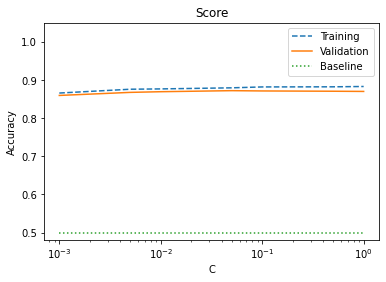

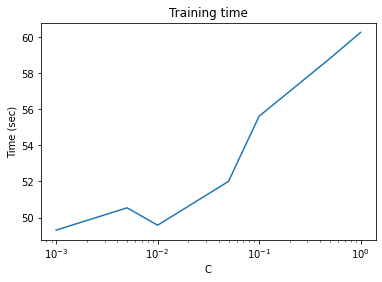

In [24]:
plot_grid_search(results, 'clf__C', xscale='log')

Training on the original training set with params = {'clf__C': 0.05}
Training time = 210.4 sec = 3.5 min
Training accuracy = 0.8778
Test accuracy = 0.8811


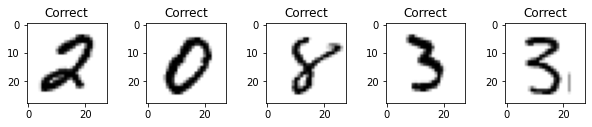

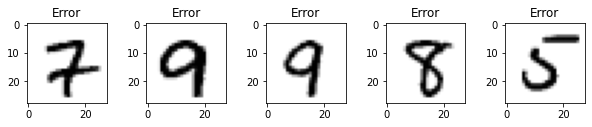

In [25]:
evaluate_model('PCA + My Linear SVM - small', pipeline, results['best_params'],
               x_train_all_small, y_train_all_small, x_test, y_test)

Το validation accuracy είναι πολύ κοντά στο train accuracy το οποίο είναι χαμηλό. Παρατηρείται υποπροσαρμογή. Το γραμμικό αυτό μοντέλο είναι πολύ απλό και δεν έχει καλές επιδόσεις ακόμα και στο training set. Ο χρόνος εκπαίδευσης αυξάνεται έντονα μετά απο C=0.1. Ο optimizer φαίνεται ότι έχει προβλήμα σύγκλισης καθώς απαιτούμε όλο και λιγότερα λάθη από το SVM. Παρόμοια αποτελέσματα παρατηρούνται και στα επόμενα δύο γραμμικά μοντέλα.

#### 4.3 PCA + Linear SVM - small

Βελτιστοποίηση του sklearn.svm.SVC με linear kernel στο μικρό training set.

In [26]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

pipeline = Pipeline([
    ('pca', PCA(n_components=0.9, svd_solver='full')),
    ('clf', SVC(kernel='linear'))
])

param_dict = {
    'clf__C': (0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.)
}

results = grid_search(pipeline, param_dict, x_train_small, y_train_small, x_val_small, y_val_small)

Best params = {'clf__C': 0.1}
Maximum validation accuracy = 0.87475


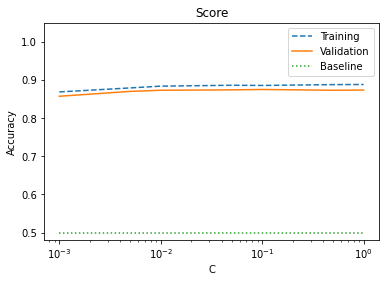

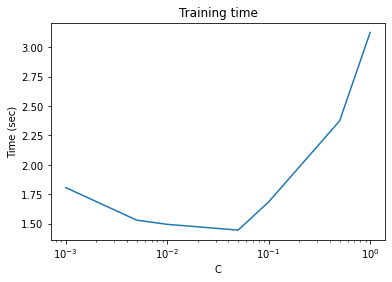

In [27]:
plot_grid_search(results, 'clf__C', xscale='log')

Training on the original training set with params = {'clf__C': 0.1}
Training time = 4.3 sec = 0.1 min
Training accuracy = 0.882
Test accuracy = 0.8852


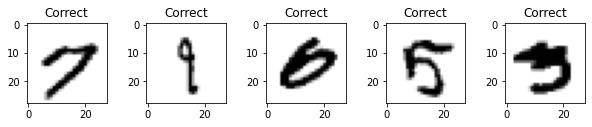

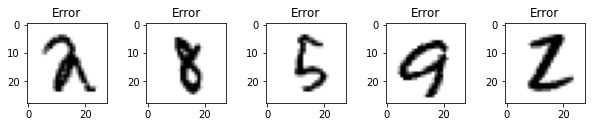

In [28]:
evaluate_model('PCA + Linear SVM - small', pipeline, results['best_params'],
               x_train_all_small, y_train_all_small, x_test, y_test)

#### 4.4 PCA + Linear SVM

Βελτιστοποίηση του sklearn.svm.SVC με linear kernel σε ολόκληρο το training set.

In [29]:
pipeline = Pipeline([
    ('pca', PCA(n_components=0.9, svd_solver='full')),
    ('clf', SVC(kernel='linear'))
])

param_dict = {
    'clf__C': (0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.)
}

results = grid_search(pipeline, param_dict, x_train, y_train, x_val, y_val)

Best params = {'clf__C': 0.5}
Maximum validation accuracy = 0.88325


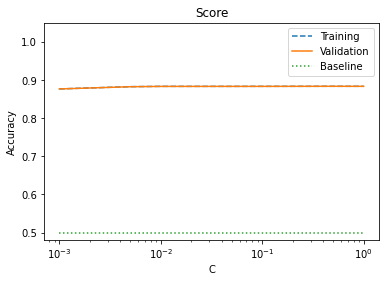

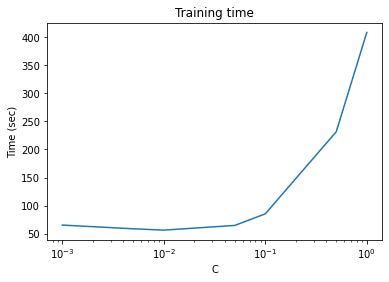

In [30]:
plot_grid_search(results, 'clf__C', xscale='log')

Training on the original training set with params = {'clf__C': 0.5}
Training time = 674.5 sec = 11.2 min
Training accuracy = 0.8835333333333333
Test accuracy = 0.8873


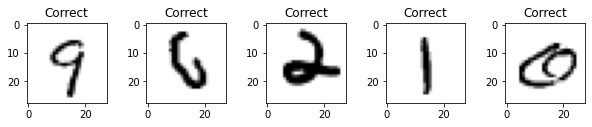

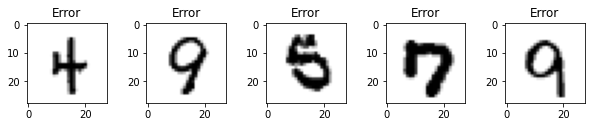

In [31]:
evaluate_model('PCA + Linear SVM', pipeline, results['best_params'],
               x_train_all, y_train_all, x_test, y_test)

#### 4.5 PCA + My Polynomial SVM - small

Η βελτιστοποίηση του MySVM με polynomial kernel στο μικρο training set πραγματοποιείται ως προς τις παραμέτρους C και degree. Το degree είναι ο βαθμός του πολυωνύμου. Το gamma έχει την default τιμή 'scale' και υπολογίζεται ως gamma = 1/(n_features*X.var()).

Kernel: $ K(\mathbf{x}, \mathbf{z}) = (\gamma\langle\mathbf{x},\mathbf{z}\rangle+r)^d $

In [32]:
pipeline = Pipeline([
    ('pca', PCA(n_components=0.9, svd_solver='full')),
    ('clf', MySVM(kernel='poly'))
])

param_dict = {
    'clf__C': (0.001, 0.01, 0.1, 1., 10., 100., 1000.),
    'clf__degree': (2, 3, 4, 5)
}

results = grid_search(pipeline, param_dict, x_train_small, y_train_small, x_val_small, y_val_small)

Best params = {'clf__C': 10.0, 'clf__degree': 3}
Maximum validation accuracy = 0.968


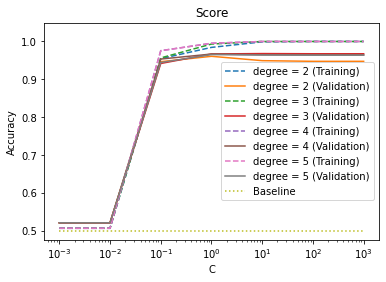

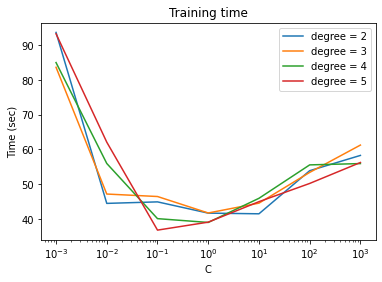

In [33]:
plot_grid_search(results, 'clf__C', 'clf__degree', xscale='log')

Training on the original training set with params = {'clf__C': 10.0, 'clf__degree': 3}
Training time = 177.9 sec = 3.0 min
Training accuracy = 0.9998
Test accuracy = 0.9762


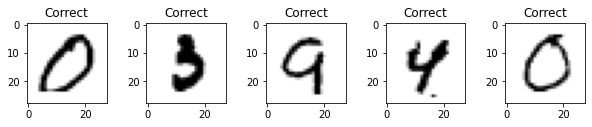

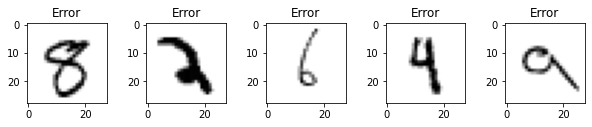

In [34]:
evaluate_model('PCA + My Polynomial SVM - small', pipeline, results['best_params'],
               x_train_all_small, y_train_all_small, x_test, y_test)

Για μικρές τιμές του C το μοντέλο έχει μεγάλο χρόνο εκπαίδευσης και δεν βρίσκει support vectors. Σ' αυτήν την περίπτωση επιλέγει τυχαία μια κλάση. Για C=1 και πάνω, η επίδοση του μοντέλου είναι πολύ καλή. Όσο αυξάνεται το C απαιτούνται όλο και λιγότερα λάθη κι έτσι αυξάνεται ο χρόνος εκπαίδευσης.

#### 4.6 PCA + Polynomial SVM - small

Βελτιστοποίηση του sklearn.svm.SVC με polynomial kernel στο μικρο training set.

In [35]:
pipeline = Pipeline([
    ('pca', PCA(n_components=0.9, svd_solver='full')),
    ('clf', SVC(kernel='poly'))
])

param_dict = {
    'clf__C': (0.001, 0.01, 0.1, 1., 10., 100., 1000.),
    'clf__degree': (2, 3, 4, 5)
}

results = grid_search(pipeline, param_dict, x_train_small, y_train_small, x_val_small, y_val_small)

Best params = {'clf__C': 100.0, 'clf__degree': 4}
Maximum validation accuracy = 0.97425


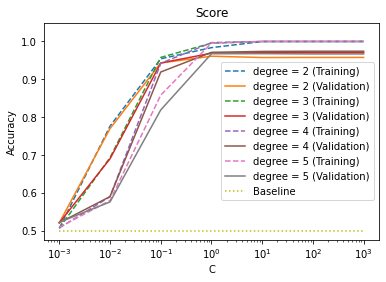

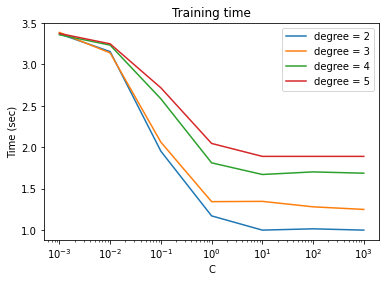

In [36]:
plot_grid_search(results, 'clf__C', 'clf__degree', xscale='log')

Training on the original training set with params = {'clf__C': 100.0, 'clf__degree': 4}
Training time = 3.9 sec = 0.1 min
Training accuracy = 1.0
Test accuracy = 0.9805


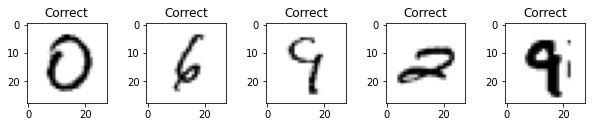

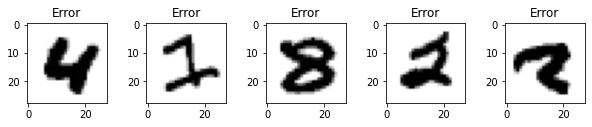

In [37]:
evaluate_model('PCA + Polynomial SVM - small', pipeline, results['best_params'],
               x_train_all_small, y_train_all_small, x_test, y_test)

Για C=1 και πάνω η επίδοση του μοντέλου είναι πολύ καλή. Όσο αυξάνεται ο βαθμός του πολυωνύμου τα μοντέλο γίνεται όλο και πιο περίπλοκο και όσο αυξάνεται το C απαιτούνται όλο και λιγότερα λάθη. Έτσι προκαλείται αύξηση του χρόνου εκπαίδευσης. Παρόμοια αποτελέσματα παρατηρούνται και στο επόμενο μοντέλο.

#### 4.7 PCA + Polynomial SVM

Βελτιστοποίηση του sklearn.svm.SVC με polynomial kernel σε ολόκληρο το training set.

In [38]:
pipeline = Pipeline([
    ('pca', PCA(n_components=0.9, svd_solver='full')),
    ('clf', SVC(kernel='poly'))
])

param_dict = {
    'clf__C': (0.001, 0.01, 0.1, 1., 10., 100., 1000.),
    'clf__degree': (2, 3, 4, 5)
}

results = grid_search(pipeline, param_dict, x_train, y_train, x_val, y_val)

Best params = {'clf__C': 1.0, 'clf__degree': 4}
Maximum validation accuracy = 0.9882083333333334


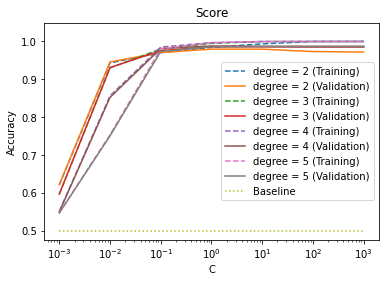

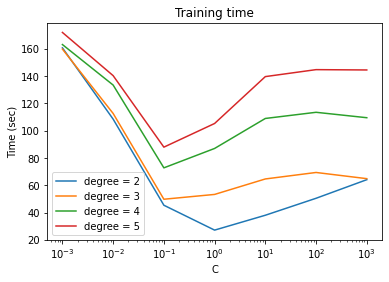

In [39]:
plot_grid_search(results, 'clf__C', 'clf__degree', xscale='log')

Training on the original training set with params = {'clf__C': 1.0, 'clf__degree': 4}
Training time = 175.6 sec = 2.9 min
Training accuracy = 0.9971666666666666
Test accuracy = 0.9909


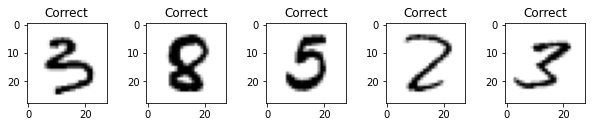

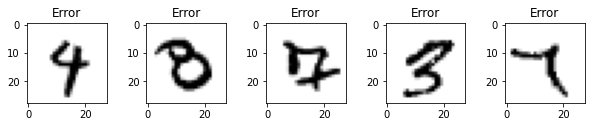

In [40]:
evaluate_model('PCA + Polynomial SVM', pipeline, results['best_params'],
               x_train_all, y_train_all, x_test, y_test)

#### 4.8 PCA + My RBF SVM - small

Η βελτιστοποίηση του MySVM με rbf kernel πραγματοποιείται ως προς τις παραμέτρους C και gamma. Το gamma δείχνει πόσο μακριά φτάνει η επιρροή ενός παραδείγματος.

Kernel: $ K(\mathbf{x}, \mathbf{z}) = e^{-\gamma||\mathbf{x}-\mathbf{z}||^2} $

In [41]:
pipeline = Pipeline([
    ('pca', PCA(n_components=0.9, svd_solver='full')),
    ('clf', MySVM(kernel='rbf'))
])

param_dict = {
    'clf__C': (0.001, 0.01, 0.1, 1., 10., 100.),
    'clf__gamma': (0.01, 0.1, 1.)
}

results = grid_search(pipeline, param_dict, x_train_small, y_train_small, x_val_small, y_val_small)

Best params = {'clf__C': 1.0, 'clf__gamma': 0.1}
Maximum validation accuracy = 0.96475


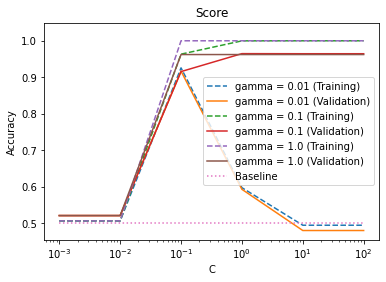

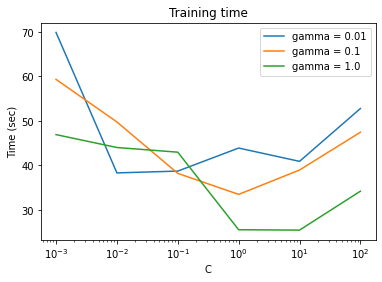

In [42]:
plot_grid_search(results, 'clf__C', 'clf__gamma', xscale='log')

Training on the original training set with params = {'clf__C': 1.0, 'clf__gamma': 0.1}
Training time = 132.6 sec = 2.2 min
Training accuracy = 0.9995
Test accuracy = 0.9768


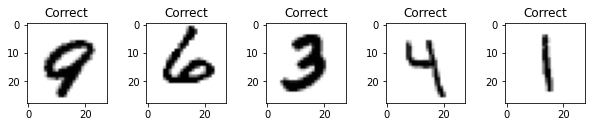

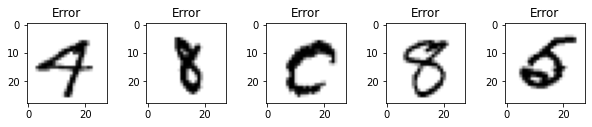

In [43]:
evaluate_model('PCA + My RBF SVM - small', pipeline, results['best_params'],
               x_train_all_small, y_train_all_small, x_test, y_test)

#### 4.9 PCA + RBF SVM - small

Βελτιστοποίηση του sklearn.svm.SVC με rbf kernel στο μικρό training set.

In [44]:
pipeline = Pipeline([
    ('pca', PCA(n_components=0.9, svd_solver='full')),
    ('clf', SVC(kernel='rbf'))
])

param_dict = {
    'clf__C': (0.001, 0.01, 0.1, 1., 10., 100.),
    'clf__gamma': (0.01, 0.1, 1.)
}

results = grid_search(pipeline, param_dict, x_train_small, y_train_small, x_val_small, y_val_small)

Best params = {'clf__C': 100.0, 'clf__gamma': 0.01}
Maximum validation accuracy = 0.9735


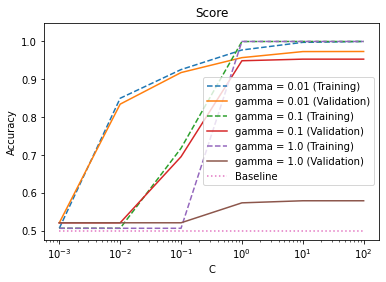

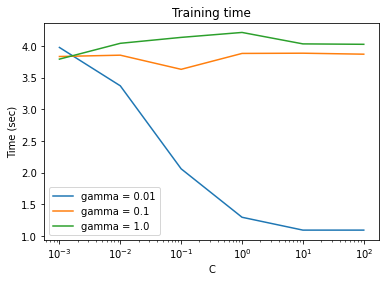

In [45]:
plot_grid_search(results, 'clf__C', 'clf__gamma', xscale='log')

Training on the original training set with params = {'clf__C': 100.0, 'clf__gamma': 0.01}
Training time = 2.5 sec = 0.0 min
Training accuracy = 1.0
Test accuracy = 0.982


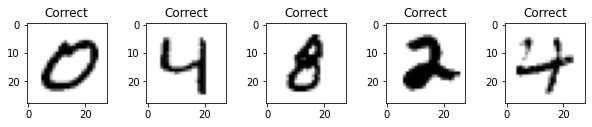

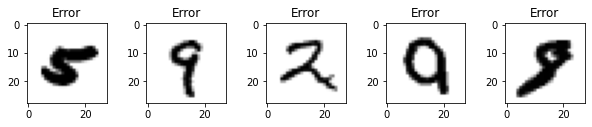

In [46]:
evaluate_model('PCA + RBF SVM - small', pipeline, results['best_params'],
               x_train_all_small, y_train_all_small, x_test, y_test)

#### 4.10 PCA + RBF SVM

Βελτιστοποίηση του sklearn.svm.SVC με rbf kernel σε ολόκληρο το training set.

In [47]:
pipeline = Pipeline([
    ('pca', PCA(n_components=0.9, svd_solver='full')),
    ('clf', SVC(kernel='rbf'))
])

param_dict = {
    'clf__C': (0.001, 0.01, 0.1, 1., 10., 100.),
    'clf__gamma': (0.01, 0.1, 1.)
}

results = grid_search(pipeline, param_dict, x_train, y_train, x_val, y_val)

Best params = {'clf__C': 10.0, 'clf__gamma': 0.01}
Maximum validation accuracy = 0.988375


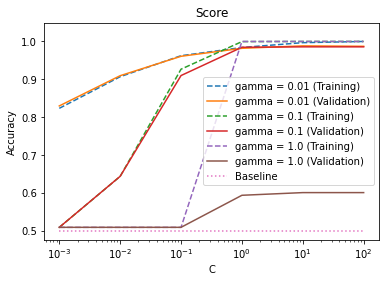

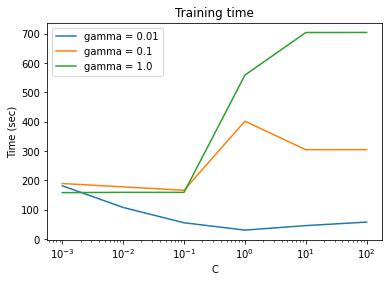

In [48]:
plot_grid_search(results, 'clf__C', 'clf__gamma', xscale='log')

Training on the original training set with params = {'clf__C': 10.0, 'clf__gamma': 0.01}
Training time = 108.8 sec = 1.8 min
Training accuracy = 0.9968166666666667
Test accuracy = 0.9906


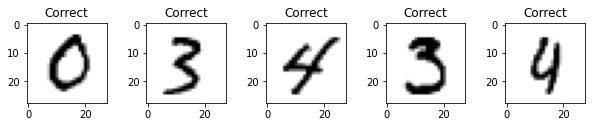

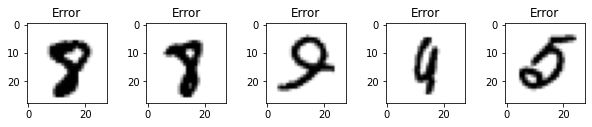

In [49]:
evaluate_model('PCA + RBF SVM', pipeline, results['best_params'],
               x_train_all, y_train_all, x_test, y_test)

Τα RBF μοντέλα έχουν καλή επίδοση καθώς αυξάνεται το C και μειώνεται το gamma αλλά αυξάνεται και ο χρόνος εκπαίδευσης.

#### 4.11 PCA + Sigmoid SVM

Η βελτιστοποίηση του svm.SVC με sigmoid kernel πραγματοποιείται ως προς τις παραμέτρους C και gamma.

Kernel: $ K(\mathbf{x}, \mathbf{z}) = tanh(\gamma\langle\mathbf{x},\mathbf{z}\rangle+r) $

In [50]:
pipeline = Pipeline([
    ('pca', PCA(n_components=0.9, svd_solver='full')),
    ('clf', SVC(kernel='sigmoid'))
])

param_dict = {
    'clf__C': (0.001, 0.01, 0.1, 1., 10., 100.),
    'clf__gamma': (0.001, 0.01, 0.1)
}

results = grid_search(pipeline, param_dict, x_train, y_train, x_val, y_val)

Best params = {'clf__C': 10.0, 'clf__gamma': 0.001}
Maximum validation accuracy = 0.8814166666666666


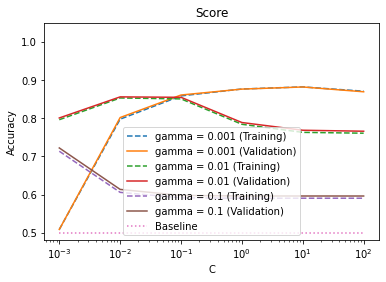

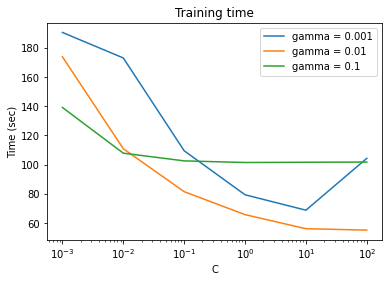

In [51]:
plot_grid_search(results, 'clf__C', 'clf__gamma', xscale='log')

Training on the original training set with params = {'clf__C': 10.0, 'clf__gamma': 0.001}
Training time = 163.3 sec = 2.7 min
Training accuracy = 0.8809666666666667
Test accuracy = 0.8853


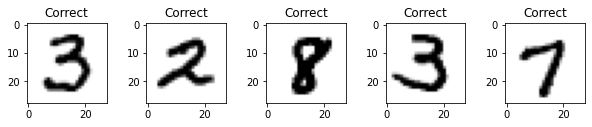

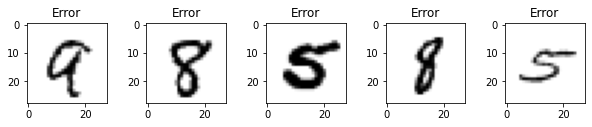

In [52]:
evaluate_model('PCA + Sigmoid SVM', pipeline, results['best_params'],
               x_train_all, y_train_all, x_test, y_test)

Τα αποτελέσματα δεν είναι καλά. Παρατηρείται υποπροσαρμογή.

#### 4.12 Nearest Class Centroid

Η βελτιστοποίηση του sklearn.neighbors.NearestCentroid πραγματοποιείται ως προς το shrink_threshold. Κάθε κλάση αντιπροσωπεύεται απο το centroid των μελών της.

In [53]:
from sklearn.neighbors import NearestCentroid

pipeline = Pipeline([
    ('clf', NearestCentroid())
])

param_dict = {
    'clf__shrink_threshold': np.arange(0, 1.1, 0.1)
}

results = grid_search(pipeline, param_dict, x_train, y_train, x_val, y_val)

Best params = {'clf__shrink_threshold': 1.0}
Maximum validation accuracy = 0.8119166666666666


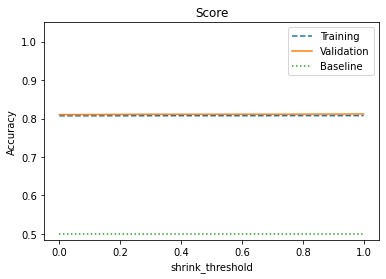

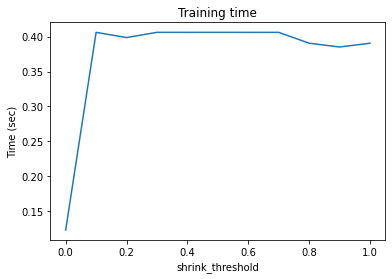

In [54]:
plot_grid_search(results, 'clf__shrink_threshold')

Training on the original training set with params = {'clf__shrink_threshold': 1.0}
Training time = 0.7 sec = 0.0 min
Training accuracy = 0.8091833333333334
Test accuracy = 0.8028


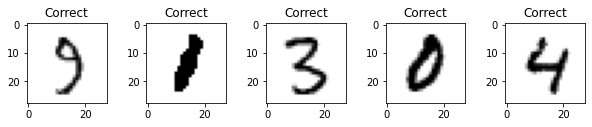

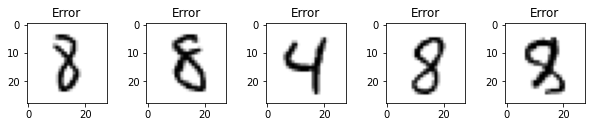

In [55]:
evaluate_model('Nearest Class Centroid', pipeline, results['best_params'],
               x_train_all, y_train_all, x_test, y_test)

Τα αποτελέσματα δεν είναι καλά. Παρατηρείται υποπροσαρμογή.

#### 4.13 PCA + Nearest Neighbors - small

Εφαρμόζεται κανονικοποίηση και μείωση των διαστάσεων με PCA διατηρώντας το 90% της διασποράς. Η βελτιστοποίηση του sklearn.neighbors.KNeighborsClassifier πραγματοποιείται ως προς τις παραμέτρους n_neighbors και p στο μικρό training set. Στον πολυδιάστατο χώρο των χαρακτηριστικών οι k πλησιέστεροι γείτονες του κάθε δείγματος ψηφίζουν για να αποφασίσουν την κλάση στην οποία ανήκει. Για να βρεθούν οι πλησιέστεροι γείτονες χρησιμοποιείται η απόσταση minkowski:

$d_p(\mathbf{x}, \mathbf{y}) = \sqrt[p]{\sum_{i}|x_i-y_i|^p}$

In [56]:
from sklearn.neighbors import KNeighborsClassifier

pipeline = Pipeline([
    ('pca', PCA(n_components=0.9, svd_solver='full')),
    ('clf', KNeighborsClassifier())
])

param_dict = {
    'clf__n_neighbors': (1, 2, 5, 10),
    'clf__p': (1, 2)
}

results = grid_search(pipeline, param_dict, x_train_small, y_train_small, x_val_small, y_val_small)

Best params = {'clf__n_neighbors': 2, 'clf__p': 2}
Maximum validation accuracy = 0.96275


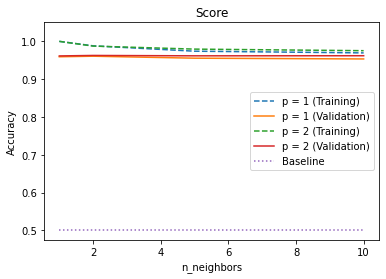

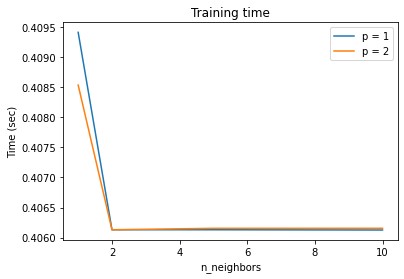

In [57]:
plot_grid_search(results, 'clf__n_neighbors', 'clf__p')

Training on the original training set with params = {'clf__n_neighbors': 2, 'clf__p': 2}
Training time = 0.7 sec = 0.0 min
Training accuracy = 0.9883
Test accuracy = 0.9763


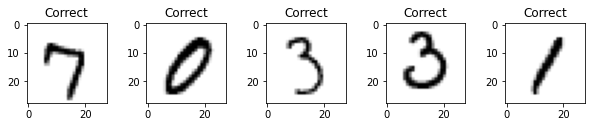

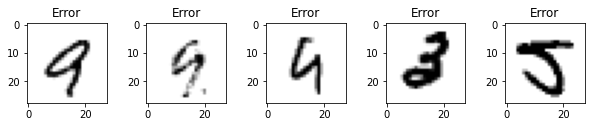

In [58]:
evaluate_model('PCA + Nearest Neighbors - small', pipeline, results['best_params'],
               x_train_all_small, y_train_all_small, x_test, y_test)

Παρατηρούνται καλά αποτελέσματα και στο training και στο validation set.

#### 4.14 Linear kPCA + LDA + Nearest Neighbors - small

Εφαρμόζεται kPCA με linear kernel και LDA. Η βελτιστοποίηση του sklearn.neighbors.KNeighborsClassifier πραγματοποιείται ως προς τις παραμέτρους n_neighbors και p στο μικρό training set. Το sklearn.discriminant_analysis.LinearDiscriminantAnalysis χρησιμοποιεί svd solver.

In [59]:
from sklearn.decomposition import KernelPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

pipeline = Pipeline([
    ('kpca', KernelPCA(kernel='linear')),
    ('lda', LinearDiscriminantAnalysis()),
    ('clf', KNeighborsClassifier())
])

param_dict = {
    'clf__n_neighbors': (1, 2, 5, 10),
    'clf__p': (1, 2)
}

results = grid_search(pipeline, param_dict, x_train_small, y_train_small, x_val_small, y_val_small)

Best params = {'clf__n_neighbors': 10, 'clf__p': 1}
Maximum validation accuracy = 0.865


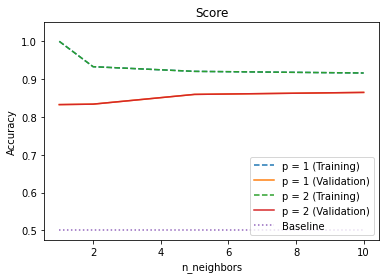

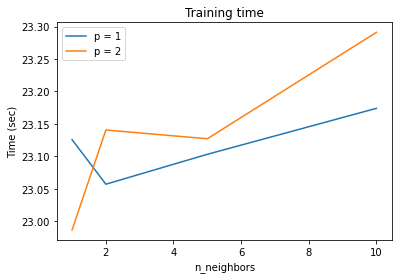

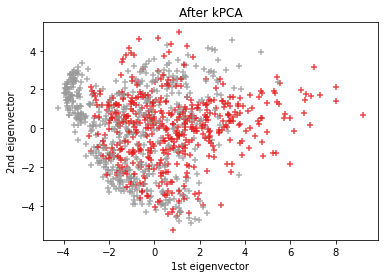

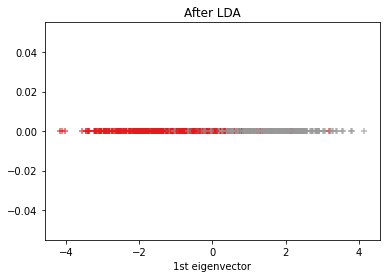

x_train.shape (6000, 784)
x_train_pca.shape = (6000, 651)
x_train_lda.shape = (6000, 1)


In [60]:
plot_grid_search(results, 'clf__n_neighbors', 'clf__p')

Training on the original training set with params = {'clf__n_neighbors': 10, 'clf__p': 1}
Training time = 103.9 sec = 1.7 min
Training accuracy = 0.9057
Test accuracy = 0.8811


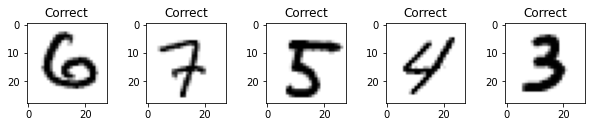

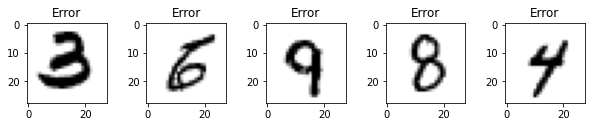

In [61]:
evaluate_model('Linear kPCA + LDA + Nearest Neighbors - small', pipeline, results['best_params'],
               x_train_all_small, y_train_all_small, x_test, y_test)

Το μοντέλο αδυνατεί να αναπαραστήσει τα δεδομένα. Μετά το LDA οι κλάσεις φαίνεται ότι δεν είναι διαχωρισμένες. Ίδια αποτελέσματα παρατηρούνται και στο επόμενο μοντέλο.

#### 4.15 My Linear kPCA + My LDA + Nearest Neighbors - small

Εφαρμόζεται kPCA με linear kernel και LDA. Η βελτιστοποίηση του sklearn.neighbors.KNeighborsClassifier πραγματοποιείται ως προς τις παραμέτρους n_neighbors και p στο μικρό training set.

In [62]:
pipeline = Pipeline([
    ('kpca', MyKernelPCA(kernel='linear')),
    ('lda', MyLinearDiscriminantAnalysis()),
    ('clf', KNeighborsClassifier())
])

param_dict = {
    'clf__n_neighbors': (1, 2, 5, 10),
    'clf__p': (1, 2)
}

results = grid_search(pipeline, param_dict, x_train_small, y_train_small, x_val_small, y_val_small)

Best params = {'clf__n_neighbors': 10, 'clf__p': 1}
Maximum validation accuracy = 0.865


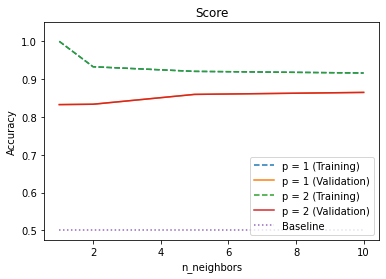

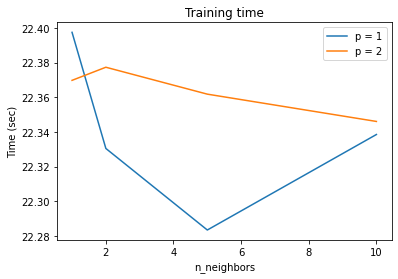

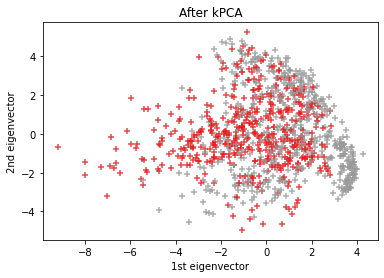

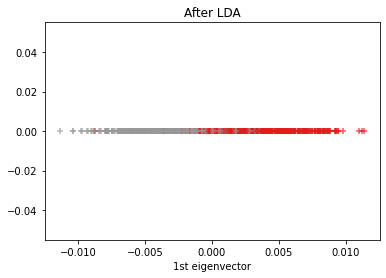

x_train.shape (6000, 784)
x_train_pca.shape = (6000, 651)
x_train_lda.shape = (6000, 1)


In [63]:
plot_grid_search(results, 'clf__n_neighbors', 'clf__p')

Training on the original training set with params = {'clf__n_neighbors': 10, 'clf__p': 1}
Training time = 101.5 sec = 1.7 min
Training accuracy = 0.9057
Test accuracy = 0.8812


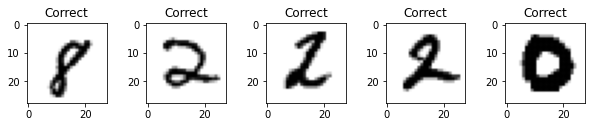

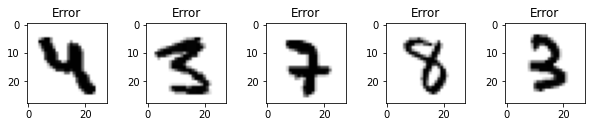

In [64]:
evaluate_model('My Linear kPCA + My LDA + Nearest Neighbors - small', pipeline, results['best_params'],
               x_train_all_small, y_train_all_small, x_test, y_test)

#### 4.16 Polynomial kPCA + LDA + Nearest Neighbors - small

Εφαρμόζεται kPCA με polynomial kernel και LDA. Η βελτιστοποίηση του sklearn.neighbors.KNeighborsClassifier πραγματοποιείται ως προς την παράμετρο n_neighbors και του sklearn.decomposition.KernelPCA ως προς την παράμετρο degree στο μικρό training set.

In [65]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import KernelPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

pipeline = Pipeline([
    ('kpca', KernelPCA(kernel='poly')),
    ('lda', LinearDiscriminantAnalysis()),
    ('clf', KNeighborsClassifier())
])

param_dict = {
    'clf__n_neighbors': (1, 2, 5, 10),
    'kpca__degree': (2, 3, 4, 5)
}

results = grid_search(pipeline, param_dict, x_train_small, y_train_small, x_val_small, y_val_small)

Best params = {'clf__n_neighbors': 10, 'kpca__degree': 4}
Maximum validation accuracy = 0.60925


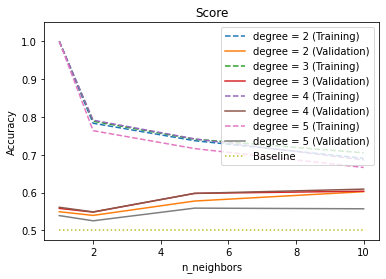

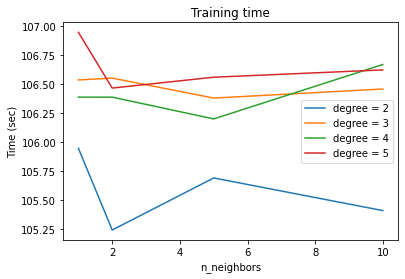

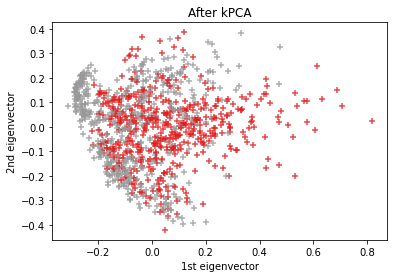

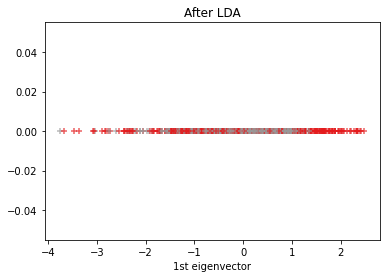

x_train.shape (6000, 784)
x_train_pca.shape = (6000, 5999)
x_train_lda.shape = (6000, 1)


In [66]:
plot_grid_search(results, 'clf__n_neighbors', 'kpca__degree')

Training on the original training set with params = {'clf__n_neighbors': 10, 'kpca__degree': 4}
Training time = 467.4 sec = 7.8 min
Training accuracy = 0.6827
Test accuracy = 0.6043


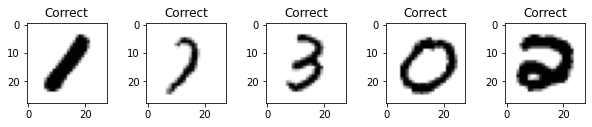

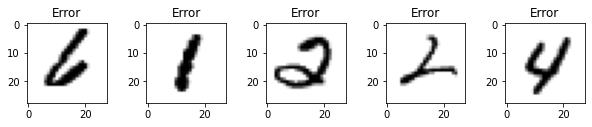

In [67]:
evaluate_model('Polynomial kPCA + LDA + Nearest Neighbors - small', pipeline, results['best_params'],
               x_train_all_small, y_train_all_small, x_test, y_test)

Τα αποτελέσματα δεν είναι καλά και οι κλάσεις δεν έχουν διαχωριστεί μετά το LDA.

#### 4.17 My Polynomial kPCA + My LDA + Nearest Neighbors - small

Εφαρμόζεται kPCA με polynomial kernel και LDA. Η βελτιστοποίηση του KNeighborsClassifier πραγματοποιείται ως προς την παράμετρο n_neighbors και του MyKernelPCA ως προς την παράμετρο degree στο μικρό training set.

In [68]:
pipeline = Pipeline([
    ('kpca', MyKernelPCA(kernel='poly')),
    ('lda', MyLinearDiscriminantAnalysis()),
    ('clf', KNeighborsClassifier())
])

param_dict = {
    'clf__n_neighbors': (1, 2, 5, 10),
    'kpca__degree': (2, 3, 4, 5)
}

results = grid_search(pipeline, param_dict, x_train_small, y_train_small, x_val_small, y_val_small)

Best params = {'clf__n_neighbors': 10, 'kpca__degree': 5}
Maximum validation accuracy = 0.9245


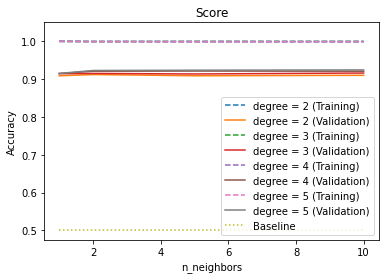

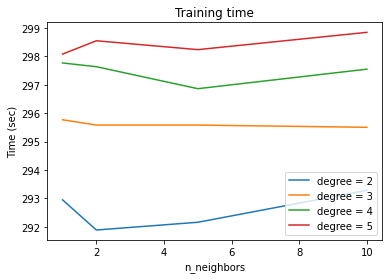

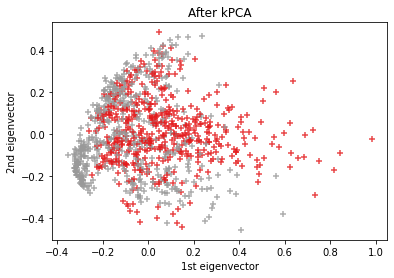

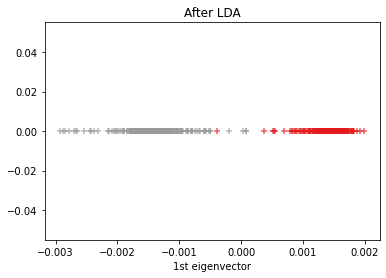

x_train.shape (6000, 784)
x_train_pca.shape = (6000, 5999)
x_train_lda.shape = (6000, 1)


In [69]:
plot_grid_search(results, 'clf__n_neighbors', 'kpca__degree')

Training on the original training set with params = {'clf__n_neighbors': 10, 'kpca__degree': 5}
Training time = 1395.3 sec = 23.3 min
Training accuracy = 0.9997
Test accuracy = 0.9172


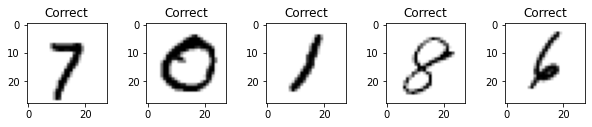

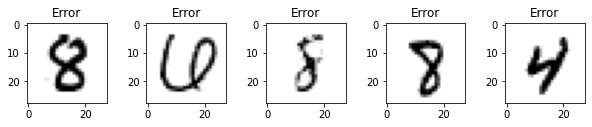

In [70]:
evaluate_model('My Polynomial kPCA + My LDA + Nearest Neighbors - small', pipeline, results['best_params'],
               x_train_all_small, y_train_all_small, x_test, y_test)

Τα αποτελέσματα είναι ικανοποιητικά και οι κλάσεις έχουν διαχωριστεί επαρκώς μετά το LDA.

#### 4.18 RBF kPCA + LDA + Nearest Neighbors - small

Εφαρμόζεται kPCA με rbf kernel και LDA. Η βελτιστοποίηση του sklearn.neighbors.KNeighborsClassifier πραγματοποιείται ως προς την παράμετρο n_neighbors και του sklearn.decomposition.KernelPCA ως προς την παράμετρο gamma στο μικρό training set.

In [71]:
pipeline = Pipeline([
    ('kpca', KernelPCA(kernel='rbf')),
    ('lda', LinearDiscriminantAnalysis()),
    ('clf', KNeighborsClassifier())
])

param_dict = {
    'clf__n_neighbors': (1, 2, 5, 10),
    'kpca__gamma': (0.01, 0.1, 1.)
}

results = grid_search(pipeline, param_dict, x_train_small, y_train_small, x_val_small, y_val_small)

Best params = {'clf__n_neighbors': 10, 'kpca__gamma': 0.1}
Maximum validation accuracy = 0.69225


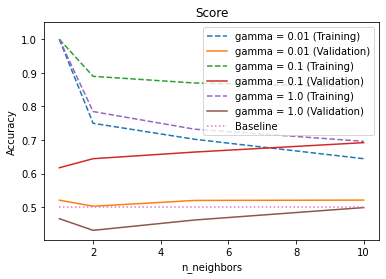

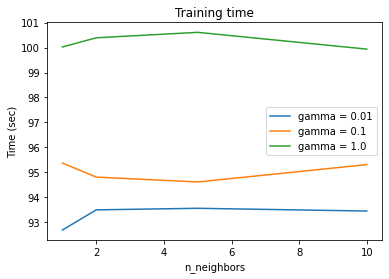

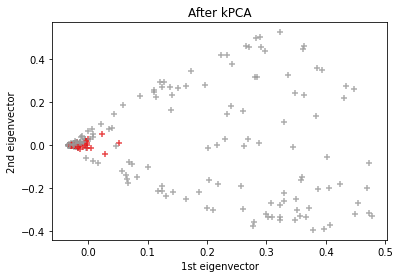

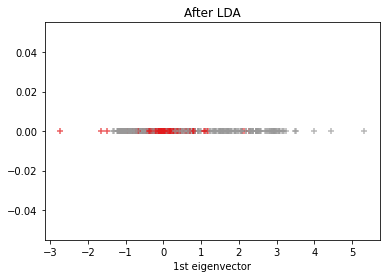

x_train.shape (6000, 784)
x_train_pca.shape = (6000, 5999)
x_train_lda.shape = (6000, 1)


In [72]:
plot_grid_search(results, 'clf__n_neighbors', 'kpca__gamma')

Training on the original training set with params = {'clf__n_neighbors': 10, 'kpca__gamma': 0.1}
Training time = 476.5 sec = 7.9 min
Training accuracy = 0.8431
Test accuracy = 0.7044


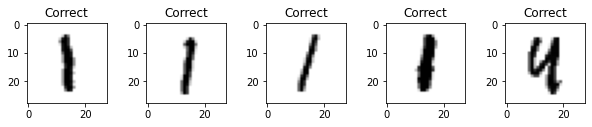

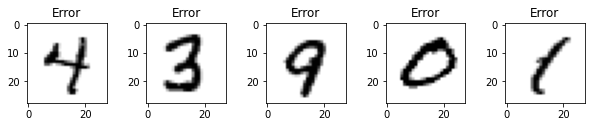

In [73]:
evaluate_model('RBF kPCA + LDA + Nearest Neighbors - small', pipeline, results['best_params'],
               x_train_all_small, y_train_all_small, x_test, y_test)

FIXME

#### 4.19 My RBF kPCA + My LDA + Nearest Neighbors - small

Εφαρμόζεται kPCA με rbf kernel και LDA. Η βελτιστοποίηση του KNeighborsClassifier πραγματοποιείται ως προς την παράμετρο n_neighbors και του MyKernelPCA ως προς την παράμετρο gamma στο μικρό training set.

In [74]:
pipeline = Pipeline([
    ('kpca', MyKernelPCA(kernel='rbf')),
    ('lda', MyLinearDiscriminantAnalysis()),
    ('clf', KNeighborsClassifier())
])

param_dict = {
    'clf__n_neighbors': (1, 2, 5, 10),
    'kpca__gamma': (0.01, 0.1, 1.)
}

results = grid_search(pipeline, param_dict, x_train_small, y_train_small, x_val_small, y_val_small)

Best params = {'clf__n_neighbors': 10, 'kpca__gamma': 0.01}
Maximum validation accuracy = 0.9535


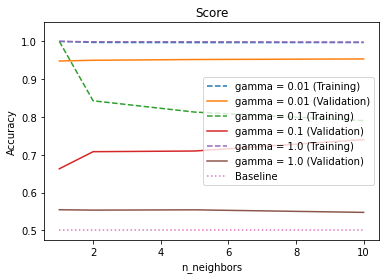

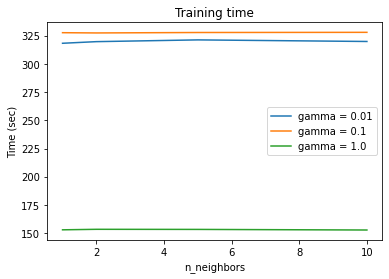

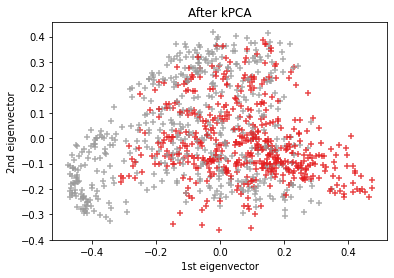

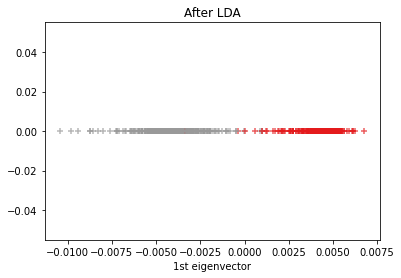

x_train.shape (6000, 784)
x_train_pca.shape = (6000, 5999)
x_train_lda.shape = (6000, 1)


In [75]:
plot_grid_search(results, 'clf__n_neighbors', 'kpca__gamma')

Training on the original training set with params = {'clf__n_neighbors': 10, 'kpca__gamma': 0.01}
Training time = 1485.0 sec = 24.8 min
Training accuracy = 0.9984
Test accuracy = 0.9627


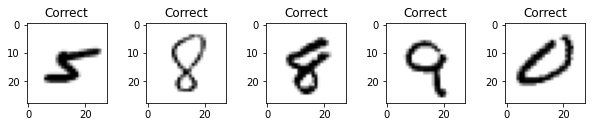

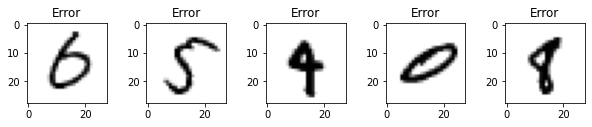

In [76]:
evaluate_model('My RBF kPCA + My LDA + Nearest Neighbors - small', pipeline, results['best_params'],
               x_train_all_small, y_train_all_small, x_test, y_test)

FIXME

### 5. Σύνοψη αποτελεσμάτων

Συνοπτικά αποτελέσματα σε ολόκληρο το training set:

In [77]:
df_columns = [x[0] for x in final_results[0]]
df_data = [dict(x) for x in final_results]
final_results_df = pd.DataFrame(df_data, columns=df_columns)
final_results_df = final_results_df.style.set_table_styles([dict(selector='th', props=[('text-align', 'left')])])
final_results_df.set_properties(**{'text-align': 'left'}).hide_index()

Classifier,Training Accuracy,Test Accuracy,Training Time (sec),Parameters
Dummy Classifier,0.5084,0.5074,0.0,strategy = 'most_frequent'
PCA + Linear SVM,0.8835,0.8873,674.5,C = 0.5000
PCA + Polynomial SVM,0.9972,0.9909,175.6,"C = 1.0000, degree = 4"
PCA + RBF SVM,0.9968,0.9906,108.8,"C = 10.0000, gamma = 0.0100"
PCA + Sigmoid SVM,0.8810,0.8853,163.3,"C = 10.0000, gamma = 0.0010"
Nearest Class Centroid,0.8092,0.8028,0.7,shrink_threshold = 1.0000


Συνοπτικά αποτελέσματα στο μικρό training set:

In [78]:
df_columns = [x[0] for x in final_results_small[0]]
df_data = [dict(x) for x in final_results_small]
final_results_df = pd.DataFrame(df_data, columns=df_columns)
final_results_df = final_results_df.style.set_table_styles([dict(selector='th', props=[('text-align', 'left')])])
final_results_df.set_properties(**{'text-align': 'left'}).hide_index()

Classifier,Training Accuracy,Test Accuracy,Training Time (sec),Parameters
PCA + My Linear SVM,0.8778,0.8811,210.4,C = 0.0500
PCA + Linear SVM,0.8820,0.8852,4.3,C = 0.1000
PCA + My Polynomial SVM,0.9998,0.9762,177.9,"C = 10.0000, degree = 3"
PCA + Polynomial SVM,1.0000,0.9805,3.9,"C = 100.0000, degree = 4"
PCA + My RBF SVM,0.9995,0.9768,132.6,"C = 1.0000, gamma = 0.1000"
PCA + RBF SVM,1.0000,0.9820,2.5,"C = 100.0000, gamma = 0.0100"
PCA + Nearest Neighbors,0.9883,0.9763,0.7,"n_neighbors = 2, p = 2"
Linear kPCA + LDA + Nearest Neighbors,0.9057,0.8811,103.9,"n_neighbors = 10, p = 1"
My Linear kPCA + My LDA + Nearest Neighbors,0.9057,0.8812,101.5,"n_neighbors = 10, p = 1"
Polynomial kPCA + LDA + Nearest Neighbors,0.6827,0.6043,467.4,"n_neighbors = 10, degree = 4"


Καλύτερες επιδόσεις έχουν τα SVM με polynomial και rbf kernel και το PCA + NearestNeighbors με accuracy μεταξύ 0.97 και 0.99. Αντιθέτως τα SVM με linear και sigmoid kernel και το Nearest Class Centroid έχουν υποπροσαρμοστεί. Το MySVM έχει παρόμοια αποτελέσματα με τα SVM του sklearn αλλά μεγαλύτερο χρόνο εκπαίδευσης το οποίο οφείλεται στους μεγάλους πίνακες τους οποίους χρησιμοποιεί. Τα μη γραμμικά μοντέλα kPCA + LDA του sklearn δεν διαχωρίζουν τις κλάσεις και έχουν κακές επιδόσεις. Αντιθέτως τα My kPCA + My LDA, τα οποία χρησιμοποιούν την απλή μέθοδο διαχωρισμού δύο κλάσεων με αντιστροφή του πίνακα Sw, πετυχαίνουν καλύτερο διαχωριμό και καλές επιδόσεις. Το μειονέκτημα τους είναι ότι έχουν μεγαλύτερο χρόνο εκπαίδευσης. Τα γραμμικά kPCA + LDA έχουν ίδια αποτελέσματα.